## Transfer Learning

In this task we will show how to perfom transfer learning - one of the most important things in image processing - with PyTorch. 

Transfer Learning describes the process of using an already trained network and retraining only a few layers in order to match our specific task.

We previously learned that the convolutional layers in our model are used for feature extraction. This means we can take one of the best performing model (eg. VGG-19) and use their pretrained convolutional layers in order to extract the features of our images and then we retrain the fully connected layers at the end of the network to match our fruit classification task.

In [17]:
import warnings
warnings.simplefilter("ignore", UserWarning)
import torch
import torch.nn as nn
import torch.optim as optim 
import torchvision

# The file helper_functions.py includes functions which perform the steps done in exercise 1
#from helper_functions import create_dataloader, train_validate_model

import os
import numpy as np
import itertools
import pandas as pd



from sklearn.preprocessing import LabelEncoder

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim 
from PIL import Image

import matplotlib.pyplot as plt

torch.manual_seed(0)

Inspecting the data
First we give you a short overview of the structure of the data, so that you have all the necessary information for building a DataLoader and your first model.

Folder Structure as follows:

* data
    * class1
        * image1
        * image2

    * class2
        * image3
        * image4

    * ...


First we get all folder names in the 'data' folder and save them as our class names.

In [18]:
#datafolder = '..\\data\\frames'
datafolder = 'C:\\Users\\cwimmer\\OneDrive - Capgemini\\Projekte\\similarity-modelling\\data\\frames'
#             'C:\\Users\\cwimmer\\OneDrive - Capgemini\\Projekte\\Similarity Modelling 2\\data\\frames'
classes = os.listdir(datafolder)

Next we fit a Label Encoder to transform our class names to integers and then create a dataframe which contains all image paths and thei respective class.

In [19]:
label_encoder = LabelEncoder().fit(classes)

data_df = pd.DataFrame(columns=['image_path', 'label'])

for class_ in classes:
    for image in os.listdir(datafolder + '\\' + class_):
        row = {'image_path': datafolder + '\\' + class_+ '\\' + image, 'label':label_encoder.transform([class_])[0]}
        data_df = data_df.append(row, ignore_index=True)

data_df.head()

,image_path,label
0,C:\Users\cwimmer\OneDrive - Capgemini\Projekte...,0
1,C:\Users\cwimmer\OneDrive - Capgemini\Projekte...,0
2,C:\Users\cwimmer\OneDrive - Capgemini\Projekte...,0
3,C:\Users\cwimmer\OneDrive - Capgemini\Projekte...,0
4,C:\Users\cwimmer\OneDrive - Capgemini\Projekte...,0


In [20]:
data_df.iloc[0][0]

'C:\\Users\\cwimmer\\OneDrive - Capgemini\\Projekte\\similarity-modelling\\data\\frames\\kermit\\Muppets-02-01-01_f1000.jpg'

Now we shuffle our dataset and then split it in a train, validation and test dataset.

In [21]:
data_df = shuffle(data_df, random_state=0)
train_val_df, test_df = train_test_split(data_df, random_state=0, test_size=0.2)
train_df, val_df = train_test_split(train_val_df, random_state=0, test_size=0.2)
print('# Train-Examples>>> {}\n# Val-Examples \t>>> {}\n# Test-Examples >>> {}\n'.format(len(train_df), len(val_df), len(test_df)))

# Train-Examples>>> 1488
# Val-Examples 	>>> 372
# Test-Examples >>> 466



## Creating a PyTorch Dataset

This Dataset Class should inhert the torch.utils.data.Dataset class and overwrite the __init__, __len__ and __getitem__ methods.


In [22]:
class imageDataset(torch.utils.data.Dataset):
    
    def __init__(self, data_loader_df, transform):
        self.name_frame = data_loader_df
        self.transform = transform
    
    def __len__(self):
        '''Return the length of the dataframe as an integer'''
        length = len(self.name_frame)
        return length

    def __getitem__(self, idx):
        '''
        1. Get the path of the image with the index
        2. open the Image with the PIL Library
        3. transform the image with the transformer
        4. get the label of the image witht the index
        5. retrun the sample as a tuple
        '''
        img_name = self.name_frame.iloc[idx].image_path
        image = Image.open(img_name)
        image = image.convert('RGB')
        image = self.transform(image)
        label = self.name_frame.iloc[idx].label
        sample = (image, label)
        return sample

A transformer object is accessible under imageTransformer.

In [23]:
resize_size = 260 # smallest side of image resized to 255px
output_size = 256 # image cropped so it has size 244x244px

imageTransformer = transforms.Compose([
    transforms.Resize((resize_size)),
    transforms.CenterCrop(output_size),
    transforms.ToTensor()
])

## Create the PyTorch Datasets

Now we use our implemented class to create the train, test and validation dataset as PyTorch datasets.

_Side Note: The test set is not used in this Example but it is common to validate and compare different models with the validation set and then test the best model on this unused test set. This is done to avoid overfitting a model only to the validation set which does not generalize to unseen data._

In [24]:
train_dataset = imageDataset(train_df, transform=imageTransformer)
test_dataset = imageDataset(test_df, transform=imageTransformer)
val_dataset = imageDataset(val_df, transform=imageTransformer)

In [25]:
# test our datasets by printing the shape of the first sample image
train_dataset[0][0].shape

torch.Size([3, 256, 256])

The shape of our images is: (channels, height, width) with channels being the red, green and blue channel in RGB.

## Create a PyTorch Dataloader

Next we want to create Dataloader Objects for out datasets which can be used to train our model. This Dataloader object should be used in that way:

for images, labels in dataloader:
    model.train(images, labels)
    

* images as tensor with shape (batch_size, channels, height, width)
* labels as tensor with shape (batch_size)


Therefor we use the torch.utils.data.DataLoader class to transform our datasets in dataloader. But first we have to define the batch size to use.


In [26]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size)
# train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size)

The worker paramter defines how many python subprocesses should be launched to load the data while training. This is especially usefull when training with a gpu.

In [27]:
# test our dataloader by printing the shape of the first batch
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 256, 256])
torch.Size([32])


### Load pretrained VGG-19 Model

In [28]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
vgg19 = torchvision.models.vgg19(pretrained=True, progress=True)

In [29]:
# print the model to see all layers
print(vgg19)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

The Output above shows the model architecture of the VGG-19 Model. We can see that the layers are groups in 3 Groups. The first group consists of Convolutional and Pooling Layers and is used to extract features (like the name suggests). The second group is a single Average Pooling Layer. The thrid and last layer is used to classify the images in the respective groups.

There are 3 fully connected Layers whereas the last the output layer is. We can see, that the last layer has 1000 Out-Features - this means that this model was trained to classify 1000 different classes. However, over task is only to classify between kirmet and not kirmet.

Therefore we have to change the last layer to only output 2 different out_features. This is done by getting the in_features (we could also just read them from above) and then changing the last layer with a new layer which has the same in_features but only out 2 out_features.

In [30]:
# reshape the last layer to match class size
in_features = vgg19.classifier[6].in_features
vgg19.classifier[6] = nn.Linear(in_features, 2)

Now that our network architecture fits our task we only have one last thing to do.

We have to 'freeze' the first two layer groups. This is done by telling the parameters of the layers that they do not have to calculate the gradients during training. This is done by setting the requires_grad parameter to False. 

We now iterate over every group and then over every layer and set the requires_grad paramter to False except the group is calles classifier.

In [31]:
for name, child in vgg19.named_children():
    if name in ['classifier']:
        print(name + ' has been unfrozen.')
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name + ' has been frozen.')
        for param in child.parameters():
            param.requires_grad = False

features has been frozen.
avgpool has been frozen.
classifier has been unfrozen.


Now our model is ready to be trained. If we now call our training function only the layers in the classifer group will be trained. 

## Define Hyperparamters

In this task we define 2 very important Hyperparamters for out training.

1. The Optimizer Function (in torch.optim module)
2. The Loss Criterion (in torch.nn module)

We use the Adam Optimizer and the Cross Entropy Loss.


In [32]:
## Set Hyperparamters (same as previous exercises)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg19.parameters(), lr=3e-4)
epochs = 10

vgg19 = vgg19.to(device)

## Train and Validate Model

In [33]:
def train_validate_model(model, model_name, train_loader, val_loader, optimizer, criterion, epochs, device=torch.device('cpu')):
    
    case_list = []
    
    for epoch in range(epochs):
        print('Epoch {} ...'.format(epoch+1))
        
        ### Train
            # initialize metrics for training
        train_loss = train_accuracy = counter = 0
        # for-loop 
        for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Clear optimizer
                optimizer.zero_grad()
                # Forward pass
                output = model.forward(inputs)
                # Loss
                loss = criterion(output, labels)
                # calculate gradients (backpropogation)
                loss.backward()
                # Adjust parameters based on gradients
                optimizer.step()
                # Add the loss to the training set's running loss
                train_loss += loss.item()*inputs.size(0)
                # Calcuate Train_Accuracy
                top_p, top_class = output.topk(1, dim=1)
                # See how many of the classes were correct?
                equals = top_class == labels.view(*top_class.shape)            
                # Calculate the mean (get the accuracy for this batch)
                # and add it to the running accuracy for this epoch
                train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()


                # Print the progress of our training
                counter += 1
                print('{}{}{} Train-Batches Progressed\r'.format(counter, "/", len(train_loader)), end="")

        train_loss = round(train_loss/len(train_loader.dataset), 4)
        train_accuracy = round(train_accuracy/len(train_loader), 4)
        print('Training Loss: {} \t\tTraining Accuracy: {}'.format(train_loss, train_accuracy))
 
        # save model
#        torch.save(model.state_dict(), 'C:\\Users\\cwimmer\\OneDrive - Capgemini\\Projekte\\Similarity Modelling 2\\src\\Computer Vision\\models\\transfer_learning\\{}-epoch-{}-val_acc-{}.pt'.format(model_name,(epoch+1), val_accuracy))
   
        
        
        ### Validation
        # initialize metrics for every epoch
        val_loss = val_accuracy = counter = 0
        
        y_true = torch.tensor([], dtype=torch.long, device=device)
        all_outputs = torch.tensor([], device=device)
        
        
        # Tell torch not to calculate gradients
        with torch.no_grad():
            for inputs, labels in val_loader:  
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Forward pass
                output = model.forward(inputs)            
                # Calculate Loss
                valloss = criterion(output, labels)            
                # Add loss to the validation set's running loss
                val_loss += valloss.item()*inputs.size(0)
                # Since our model outputs a LogSoftmax, find the real           
                # Get the top class of the output
                top_p, top_class = output.topk(1, dim=1)


                # See how many of the classes were correct?
                equals = top_class == labels.view(*top_class.shape)            
                # Calculate the mean (get the accuracy for this batch)
                # and add it to the running accuracy for this epoch
                val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                # Print the progress of our evaluation
                counter += 1
                
                # catinate all true labels
                y_true = torch.cat((y_true, labels), 0)
                # catinate all predicted labes
                all_outputs = torch.cat((all_outputs, output), 0)
                
                
                print('{}{}{} Validation-Batches Progressed\r'.format(counter, "/", len(val_loader)), end="")
        
        ### store the metrics for graphs, confusion matrix, ROC and AUC for later
        # y_true to numpy
        y_true = y_true.cpu().numpy()  
        # y_pred to numpy (all_outputs)
        _, y_pred = torch.max(all_outputs, 1)
        
        # y_pred to numpy (all_outputs)
        y_pred = y_pred.cpu().numpy()
        # get prediction probability of all outputs to numpy
        y_pred_prob = F.softmax(all_outputs, dim=1).cpu().numpy()
        
   
        
        # Get the average loss for the entire epoch
        val_loss = round(val_loss/len(val_loader.dataset), 4)
        val_accuracy = round(val_accuracy/len(val_loader), 4)
        # Print out the information
        print('Validation Loss:  {} \tValidation Accuracy: {}'.format(val_loss, val_accuracy))
        
        # save model
        torch.save(model.state_dict(), 'C:\\Users\\cwimmer\\OneDrive - Capgemini\\Projekte\\similarity-modelling\\src\\Computer Vision\\models\\transfer_learning\\{}-epoch-{}-val_acc-{}.pt'.format(model_name,(epoch+1), val_accuracy))

        # save every metric in a dict
        case = {'train_accuracy': train_accuracy, 'train_loss': train_loss,
                                  'val_accuracy': val_accuracy, 'val_loss': val_loss, 'y_true' : y_true,
                                  'y_pred' : y_pred, 'y_pred_prob' :y_pred_prob}
        
        
        # append each metric dict per epoch
        case_list.append(case)
        

        print('-------------')
    return case_list

In [34]:
kirmet_detection = 'kirmet_detection'

In [35]:
result = train_validate_model(vgg19, kirmet_detection, train_loader, val_loader, optimizer, criterion, epochs, device=device)

Epoch 1 ...
Training Loss: 0.408 		Training Accuracy: 0.8305
Validation Loss:  0.378 	Validation Accuracy: 0.8339
-------------
Epoch 2 ...
Training Loss: 0.1943 		Training Accuracy: 0.9322
Validation Loss:  0.2699 	Validation Accuracy: 0.9021
-------------
Epoch 3 ...
Training Loss: 0.1449 		Training Accuracy: 0.9435
Validation Loss:  0.2899 	Validation Accuracy: 0.9297
-------------
Epoch 4 ...
Training Loss: 0.0888 		Training Accuracy: 0.9701
Validation Loss:  0.3394 	Validation Accuracy: 0.9047
-------------
Epoch 5 ...
Training Loss: 0.0643 		Training Accuracy: 0.9854
Validation Loss:  0.3913 	Validation Accuracy: 0.8943
-------------
Epoch 6 ...
Training Loss: 0.0469 		Training Accuracy: 0.9854
Validation Loss:  0.4933 	Validation Accuracy: 0.9089
-------------
Epoch 7 ...
Training Loss: 0.1103 		Training Accuracy: 0.9727
Validation Loss:  0.8218 	Validation Accuracy: 0.8943
-------------
Epoch 8 ...
Training Loss: 0.1587 		Training Accuracy: 0.9714
Validation Loss:  0.5874 	Vali

### Plotting the Training Curve

In [41]:
def get_metrics_df(results_from_model):
    df = pd.DataFrame(results_from_model)
    df = df.drop(['y_true', 'y_pred', 'y_pred_prob'], axis=1)
#    df['val_accuracy'] = df['val_accuracy'].div(12)
#    df['val_loss'] = df['val_loss'].div(372)
    df['epoch'] = df.index + 1
    return df

In [42]:
df = get_metrics_df(result)
df.head()

,train_accuracy,train_loss,val_accuracy,val_loss,epoch
0,0.8305,0.4080,0.8339,0.3780,1
1,0.9322,0.1943,0.9021,0.2699,2
2,0.9435,0.1449,0.9297,0.2899,3
3,0.9701,0.0888,0.9047,0.3394,4
4,0.9854,0.0643,0.8943,0.3913,5


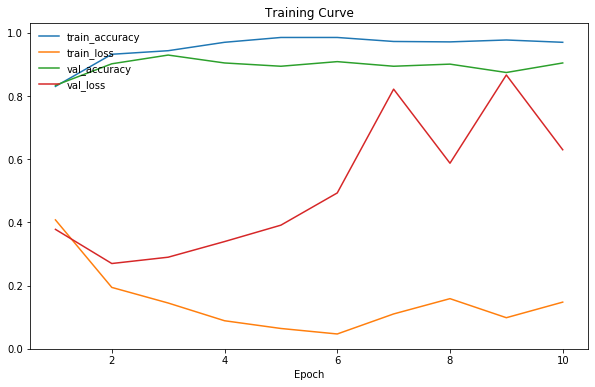

In [43]:
plt.figure(figsize=(10,6))
plt.title("Training Curve") 
plt.xlabel("Epoch")

plt.plot(df['epoch'], df['train_accuracy'], label = 'train_accuracy')
plt.plot(df['epoch'], df['train_loss'], label = 'train_loss')
plt.plot(df['epoch'], df['val_accuracy'], label = 'val_accuracy')
plt.plot(df['epoch'], df['val_loss'], label = 'val_loss')


plt.legend(loc='upper left', scatterpoints = 1, frameon=False)

plt.savefig('C:\\Users\\cwimmer\\OneDrive - Capgemini\\Projekte\\similarity-modelling\\src\\Computer Vision\\plots\\Trainingcurve_TL.png')

plt.show()

## Load Best model

In [47]:
# Initialize the Network to reset it
vgg19 = vgg19.to(device)

vgg19.load_state_dict(torch.load('C:\\Users\\cwimmer\\OneDrive - Capgemini\\Projekte\\similarity-modelling\\src\\Computer Vision\\models\\transfer_learning\\kirmet_detection-epoch-3-val_acc-0.9297.pt'))
vgg19.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## Test Model

In [48]:
def test_model(model,test_loader,criterion, device=torch.device('cpu')):
        # initialize metrics for every epoch
        test_loss = 0
        test_accuracy = 0 
        counter = 0
        
        y_true = torch.tensor([], dtype=torch.long, device=device)
        all_outputs = torch.tensor([], device=device)
        
        
        # Tell torch not to calculate gradients
        with torch.no_grad():
            for inputs, labels in test_loader:  
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Forward pass
                output = model.forward(inputs)            
                # Calculate Loss
                testloss = criterion(output, labels)            
                # Add loss to the validation set's running loss
                test_loss += testloss.item()*inputs.size(0)
                # Since our model outputs a LogSoftmax, find the real           
                # Get the top class of the output
                top_p, top_class = output.topk(1, dim=1)


                # See how many of the classes were correct?
                equals = top_class == labels.view(*top_class.shape)            
                # Calculate the mean (get the accuracy for this batch)
                # and add it to the running accuracy for this epoch
                test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                # Print the progress of our evaluation
                counter += 1

                #outputs = model(*inputs)
                y_true = torch.cat((y_true, labels), 0)
                all_outputs = torch.cat((all_outputs, output), 0)
                
                
                print('{}{}{} Test-Batches Progressed\r'.format(counter, "/", len(test_loader)), end="")
                             
        
        y_true = y_true.cpu().numpy()  
        _, y_pred = torch.max(all_outputs, 1)
        y_pred = y_pred.cpu().numpy()
        y_pred_prob = F.softmax(all_outputs, dim=1).cpu().numpy()
                
        # Get the average loss for the entire epoch
        test_loss = round(test_loss/len(test_loader.dataset), 4)
        test_accuracy = round(test_accuracy/len(test_loader), 4)
        # Print out the information
        print('Test Loss:  {} \tTest Accuracy: {}'.format(test_loss, test_accuracy))
        return test_loss, test_accuracy, y_true, y_pred, y_pred_prob

In [49]:
test_metrics = test_model(vgg19,test_loader,criterion, device=device)

Test Loss:  0.2669 	Test Accuracy: 0.9322


## ROC, Confusion Matrix, Accuracy, Recall, F1-Score with test-set

### ROC Curve

In [50]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

y_pred_prob = test_metrics[4][:, 1]

fpr, tpr, _ = roc_curve(test_metrics[2], y_pred_prob)
roc_auc = auc(fpr, tpr)

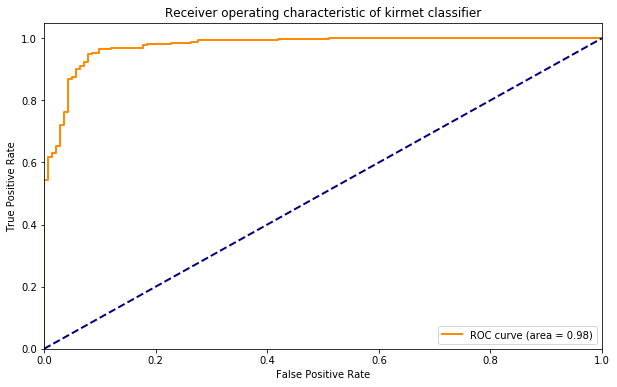

In [52]:
plt.figure(figsize=(10,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of kirmet classifier')
plt.legend(loc="lower right")


plt.savefig('C:\\Users\\cwimmer\\OneDrive - Capgemini\\Projekte\\similarity-modelling\\src\\Computer Vision\\plots\\ROC_TL.png')


plt.show()

### Classification Report

In [53]:
CATEGORIES = ['kirmet', 'no kirmet']
print(classification_report(y_true = test_metrics[2], y_pred = test_metrics[3], target_names = CATEGORIES))

              precision    recall  f1-score   support

      kirmet       0.87      0.92      0.89       141
   no kirmet       0.97      0.94      0.95       325

    accuracy                           0.93       466
   macro avg       0.92      0.93      0.92       466
weighted avg       0.94      0.93      0.93       466



### Confusion Matrix

In [57]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('C:\\Users\\cwimmer\\OneDrive - Capgemini\\Projekte\\similarity-modelling\\src\\Computer Vision\\plots\\ConfusionMatrix_TL.png')
    plt.show()

In [55]:
confusion_matrix = metrics.confusion_matrix(y_true=test_metrics[2], y_pred=test_metrics[3])


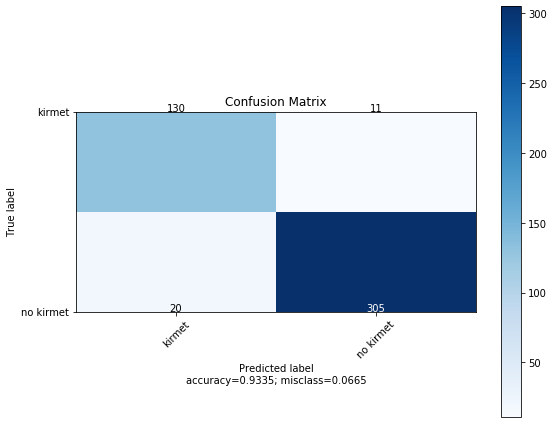

In [58]:
plot_confusion_matrix(cm           = confusion_matrix, 
                      normalize    = False,
                      target_names = CATEGORIES,
                      title        = "Confusion Matrix")